# ENGSCI205 - Engineering Machine Learning
## Hybrid Linear Models

Here, we will look at:

- Numerically solving a nonlinear ODE model representing the nonlinear pendulum, as in Lab 1, to generate data
- Fitting a hybrid data + linear ODE approximate model to the data, including
  - Learning about observation matrices
  - Learning about splines
  - Learning about finite difference matrices
- Considering the performance of this approach for various parameters and scenarios, including a) a pure data fit, b) a strongly imposed but wrong model, and c) choosing the degree to impose the model using a hold-out set of *future* data


For the hybrid model in particular, we use PyTorch tensors rather than NumPy arrays.

---


## 1. Nonlinear pendulum revisited

From Newton's 2nd Law we know that the motion of the angle of the nonlinear pendulum is described by the following ordinary differential equation (ODE):

$$
\frac{d^2 \theta}{dt^2} = -\frac{g}{l}\sin \theta,
$$

where $\theta$ is the pendulum angle, along with initial conditions:

$$
\theta(0) = \theta_0, \quad \frac{d\theta}{dt}(0) = v_0
$$

A *linear* ODE approximation, valid for *small* angles, to this is given by

$$
\frac{d^2 \theta}{dt^2} = -\frac{g}{l}\theta,
$$

---

## Deriving system from second order equation

Write, mathematically, **both** of the above second-order ODEs as *systems* of two first-order ODEs (the solver wants a system of first order ODEs). Make sure to include initial conditions.

**SYSTEM HERE **

Nonlinear:
$$
\frac{dy_1}{dt} =  y_2\\
\frac{dy_2}{dt} = -\frac{g}{l} \sin(\theta)
$$


Linear:

$$
\frac{dy_1}{dt} =  y_2\\
\frac{dy_2}{dt} = -\frac{g}{l}\theta
$$

both with initial conditions:

$$
y(0) = \theta_0, \quad \frac{dy}{dt}(0) = v_0
$$


## 2. Solving pendulum motion numerically
Use the same ODE solution approach to solve the ODE to generate plots of the fine-scale motion.

Simulate from $t$ = 0 to $t=t_{\text{pred}}$, and keep this full trajectory for later, but also split the solution into two trajectories: one corresponding to the trajectory from $t$ = 0 to $t=t_{\text{fit}}$ and the other to the trajectory from $t=t_{\text{fit}}$ to  $t=t_{\text{pred}}$. We will hold out the latter when fitting, in order to validate our predictions. **Plot both fine-scale trajectory components here, each in a different colour**.

In [239]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# setup ODE RHS
def dydt_p(t,y,prm):
    theta0 = prm[0]
    v0 = prm[1]
    l = prm[2]
    g = prm[3]
    y_var = y[0]
    dydt = y[1]
    return np.array([y[1], -g/l*np.sin(y_var)])

In [240]:
# true parameters
theta0_true = np.radians(60)
v0_true = 0
l_true = 0.5
g_true = 9.81
w_true = torch.tensor([theta0_true, v0_true, l_true, g_true], dtype=torch.float32)

In [241]:
# initial conditions (using true parameters)
y0= [theta0_true, v0_true]

# time grids
t_pred = 5
t_fit = 2
t_span=[0,t_pred]
t_span_data=[0,t_pred]
t_grid = torch.arange(t_span[0],t_span[1],0.01) #fine grid

# solve ODE for true parameters
prm = np.array(w_true)
solution = solve_ivp(dydt_p, t_span, y0, args=(prm,), t_eval=t_grid.numpy(), dense_output = True)

# extract solution for fine time grid (t_grid)
sol = solution.sol
y_true = sol(t_grid)[0]

# Keep a copy of full trajectory
full_trajectory = sol(t_grid)[0]

# Split into the trajectory up to t_fit,
split = np.where(t_grid == t_fit)

t_fit_trajectory = t_grid[:split[0][0]]
t_pred_trajectory = t_grid[split[0][0]:]

theta_fit = y_true[:split[0][0]]
theta_pred = y_true[split[0][0]:]

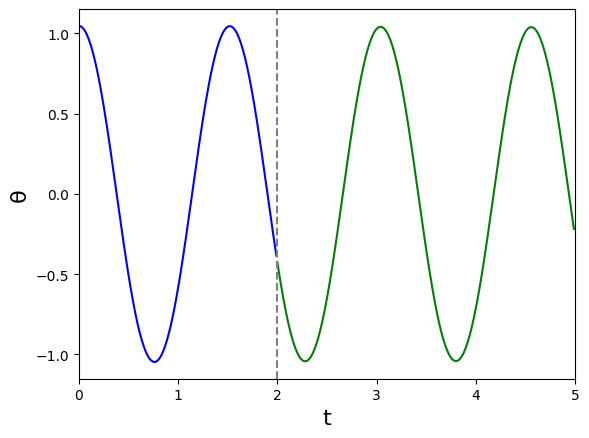

In [242]:
# Plot fine grid solution
plt.figure()
plt.plot(t_fit_trajectory, theta_fit, label='Fitting Trajectory', color='blue')
plt.plot(t_pred_trajectory, theta_pred, label='Prediction Trajectory', color='green')
plt.ylabel('θ', fontsize = 16)
plt.xlabel('t', fontsize = 16)
plt.xlim(0,5)
plt.axvline(x=t_fit, color='grey', linestyle='--', label='t_fit')

plt.show()

## 3. Observation matrices

Using the the guide in the lecture handout (if you want), construct a **function that returns and observation matrix** $A_{\text{obs}}$, as a PyTorch tensor, given inputs arguments consisting of the length (in terms of grid points) of the domain being observed and a vector of *observation indices* for the points in the domain that are observed. Illustrate that your method works on some test inputs.



In [243]:
def obs_matrix(domain_length, obs_indices):
  A_obs = torch.eye(domain_length, dtype=torch.float32)[obs_indices]
  return A_obs

In [244]:
obs_indices = [0,4,9]
domain_length = 10

y = torch.arange(10, 20, dtype=torch.float32)
A_obs = obs_matrix(domain_length, obs_indices)

y_obs = A_obs @ y

print('Fine-scale y:')
print(y)
print('\n')
print('Observation matrix:')
print(A_obs)
print('\n')
print('Observed y:')
print(y_obs)

Fine-scale y:
tensor([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])


Observation matrix:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


Observed y:
tensor([10., 14., 19.])


## 4. Splines
Create a function that uses Patsy to return a spline basis matrix (to be used for the fine time grid), as a PyTorch tensor, given arguments consisting of the time grid and the number of basis functions (excluding the constant column).

Plot the basis functions for the case of 10 spline basis functions and one constant.

In [245]:
from patsy import dmatrices, dmatrix

def basis_matrix(t, n_basis):
  B = torch.tensor(dmatrix("1 + bs(t, df, degree=3)", {"t": t, "df": n_basis}), dtype=torch.float32)
  return B

B1 = basis_matrix(t_grid, 10)

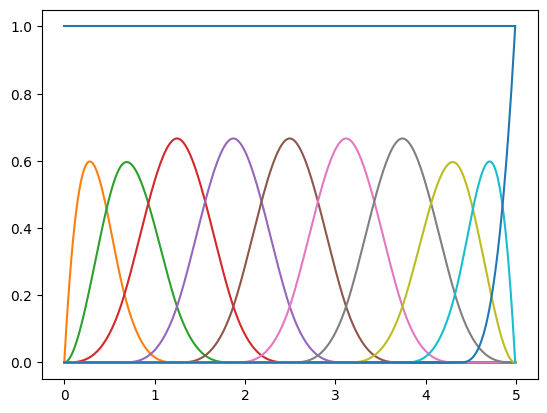

In [246]:
plt.figure()
plt.plot(t_grid, B1)
plt.show()

## 5. Fitting pure data model.

Using the components from above  
- Generate noisy data for $t$ between 0 and $t_{\text{fit}}$, taking every 10th observation, starting from the 0th index, *within this domain*.
- Fit a pure data model using a spline basis with 15 splines + 1 constant term.
- **You should make your spline basis span from 0 to $t_{\text{pred}}$ so you can plot its future prediction too.**

In [247]:
t_traj = t_fit_trajectory[::10]

In [248]:
obs_indices = torch.arange(0, split[0][0], 10)
A_obs = obs_matrix(len(t_fit_trajectory), obs_indices)

# noise to add to observed points
torch.manual_seed(42)
noise = torch.randn(A_obs.shape[0]) * 0.1

y_obs = A_obs@theta_fit + noise

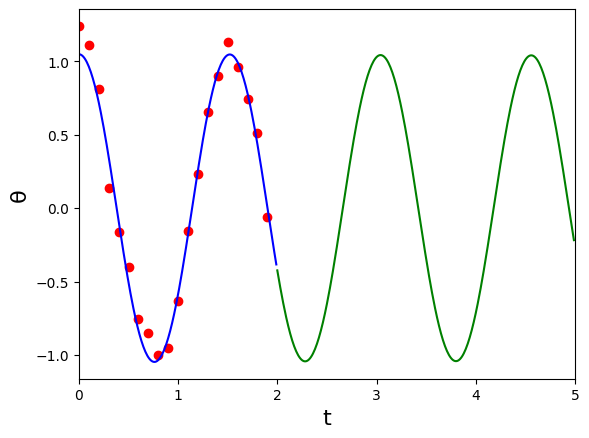

In [249]:
# Plot fine grid solution and observation points
plt.figure()
plt.scatter(t_traj, y_obs, label='True obs', color='red')
plt.plot(t_fit_trajectory, theta_fit, label='Fitting Trajectory', color='blue')
plt.plot(t_pred_trajectory, theta_pred, label='Prediction Trajectory', color='green')
plt.xlabel('t', fontsize = 16)
plt.ylabel('θ', fontsize = 16)
plt.xlim(0,5)
plt.show()

In [250]:
n_basis = 15
B = basis_matrix(t_grid, n_basis)

In [251]:
A_obs = obs_matrix(len(t_grid), obs_indices)
lstsq_results = torch.linalg.lstsq(A_obs@B, y_obs.float())
w_lstsq = lstsq_results.solution
y_fitted = B@w_lstsq

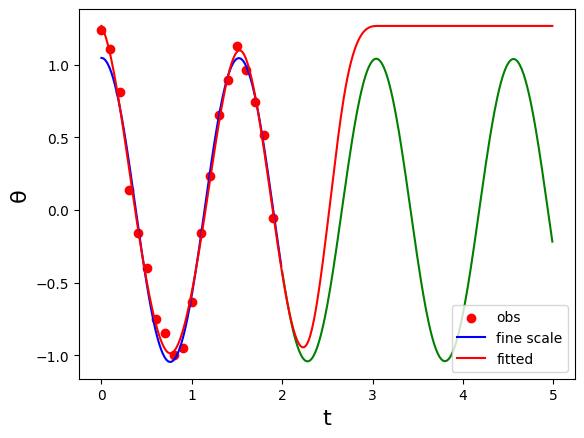

In [252]:
plt.figure()

plt.plot(t_pred_trajectory, theta_pred, color='green')
plt.scatter(t_traj, y_obs, label='obs', color='red')
plt.plot(t_fit_trajectory, theta_fit, label='fine scale', color='blue')
plt.plot(t_grid, y_fitted, label='fitted', color='red')
plt.xlabel('t', fontsize = 16)
plt.ylabel('θ', fontsize = 16)

plt.legend()
plt.show()

## 6. Derivative matrices

Following the guidance of the lecture notes, construct derivative matrices.

**First**, show how to construct a first-derivative matrix as a PyTorch tensor.

**Next**, show how to construct a second-derivative matrix and a third-derivative matrix using your first-derivative matrix.

**Next**, write a function that generalises this by first creating a first derivative matrix and then returning the $n$th order derivative matrix using this, for a user input $n$.

**Finally**, verify your answer on at least two example functions for which you know the correct derivative analytically. Produce visual comparisons for this component.

In [253]:
# First-derivative matrix
t = torch.linspace(0, 12,100, dtype=torch.float32)
dt = t[1]-t[0]
N = len(t)
y = torch.sin(t)

D = torch.zeros(N-1, N)
D[torch.arange(0, N-1), torch.arange(0, N-1)] = -1/dt
D[torch.arange(0, N-1), torch.arange(1, N)] = 1/dt
print(D*dt)

tensor([[-1.,  1.,  0.,  ...,  0.,  0.,  0.],
        [ 0., -1.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  0., -1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  0., -1.,  1.]])


In [254]:
# Second-derivative matrix
D2 = D[1:,1:]@D*dt**2
print(D2)

tensor([[ 1., -2.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  1., -2.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., -2.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  1., -2.,  1.]])


In [255]:
# n derivative matrix function
def n_derivative_matrix(n, dt, N):

  # First derivative matrix construction
  D = torch.zeros(N - 1, N)
  D[torch.arange(0, N - 1), torch.arange(0, N - 1)] = -1 / dt
  D[torch.arange(0, N - 1), torch.arange(1, N)] = 1 / dt

  # Initialise the derivative matrix
  D_n = D.clone()
  for i in range(1, n):
    D = D_n[i:, i:] @ D

  return D

In [256]:
dt = 1
D2=n_derivative_matrix(2, dt, N)
print(D2)
D3=n_derivative_matrix(3, dt, N)
print(D3)
D4=n_derivative_matrix(4, dt, N)
print(D4)

tensor([[ 1., -2.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  1., -2.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., -2.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  1., -2.,  1.]])
tensor([[-1.,  3., -3.,  ...,  0.,  0.,  0.],
        [ 0., -1.,  3.,  ...,  0.,  0.,  0.],
        [ 0.,  0., -1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., -3.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  3., -3.,  1.]])
tensor([[ 1., -4.,  6.,  ...,  0.,  0.,  0.],
        [ 0.,  1., -4.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  6., -4.,  1.]])


In [257]:
t = torch.linspace(0, 5, 100)
dt = t[1] - t[0]
N = len(t)
y = torch.exp(t)

D1 = n_derivative_matrix(1, dt, N)
D2 = n_derivative_matrix(2, dt, N)
D3 = n_derivative_matrix(3, dt, N)

d1 = D1@y
d2 = D2@y
d3 = D3@y

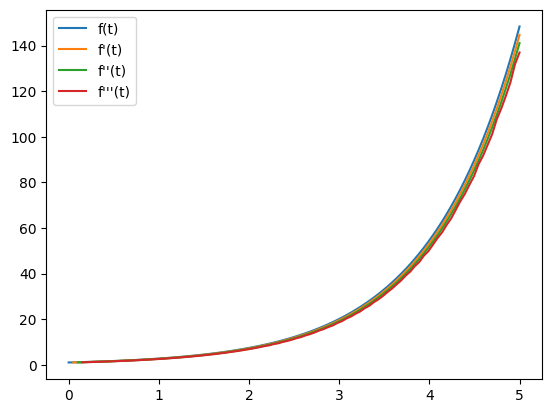

In [258]:
plt.figure()
plt.plot(t, y, label='f(t)')
plt.plot(t[1:], d1, label='f\'(t)')
plt.plot(t[2:], d2, label='f\'\'(t)')
plt.plot(t[3:], d3, label='f\'\'\'(t)')

plt.legend(loc='upper left')
plt.show()

In [259]:
t = torch.linspace(-10, 10, 200)
y = torch.cos(t)
dt = t[1] - t[0]
N = len(t)

D1 = n_derivative_matrix(1, dt, N)
D2 = n_derivative_matrix(2, dt, N)
D3 = n_derivative_matrix(3, dt, N)
D4 = n_derivative_matrix(4, dt, N)

d1 = D1@y
d2 = D2@y
d3 = D3@y
d4 = D4@y

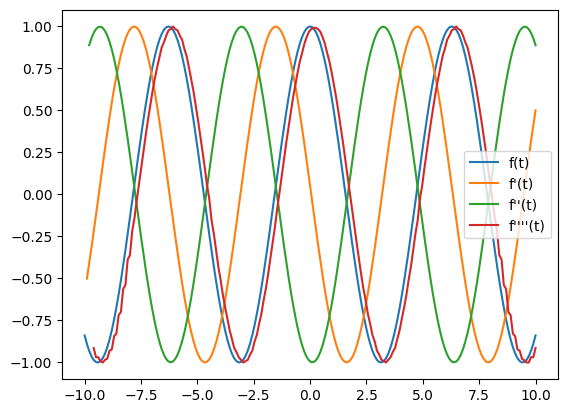

In [260]:
# plot
plt.figure()
plt.plot(t, y, label='f(t)')
plt.plot(t[1:], d1, label='f\'(t)')
plt.plot(t[2:], d2, label='f\'\'(t)')
plt.plot(t[4:], d4, label='f\'\'\'\'(t)')
plt.legend()
plt.show()

## 7. ODE-based regularisation.

Re-consider the above problem but, following the lectures for guidance, include a regularisation term in your fitting approach based on the **linear approximation** to the true ODE.

Note, the discretised equation can be written as

$$D_2Bw = -\frac{g}{l}F_{\text{obs}}Bw$$

where $D_2$ is a (backwards) second derivative matrix and $F_{\text{obs}}$ is a 'RHS observation' matrix that has the same dimensions as $D_2$ and ensures the equation is enforced at the appropriate 'internal' grid points. Since this is a backward difference, requiring two grid points to 'get started', we can enforce the equation for the **third grid point on**. You can construct $F_{\text{obs}}$ by calling your obs_matrix(domain_length, obs_indices) function with obs_indices = tensor.arange(2,domain_length). That is, we enforce the equation from grid point three (index 2) onwards.

The above can be written as

$$(D_2B + \frac{g}{l}F_{\text{obs}}B)w = 0$$

where the RHS is a *vector* of zeros of appropriate size. This equation has the form

$$Lw = 0.$$

for a matrix $L = (D_2 + \frac{g}{l}F_{\text{obs}})B$. Note the $F_{\text{obs}}$! ***Assuming $g$ and $l$ are known and equal to their true values***, this can be included as the regularisation term as in class! Hence, assuming this is the case,

- Implement additional 'regularisation' using 'stacking' and *one of* the `lstsq` or `pinv` methods, and such that the result depends on a regularisation parameter $\lambda$ that the user can choose.
- Plot your recovered solutions for a large range of $\lambda$. In particular, vary the $\lambda$ values over large ranges e.g. $10^{-15}$ to $10^{15}$. You can use e.g. `torch.logspace` or generate first powers yourself and use lambda = 10^power, and plot what happens as we go from very little regularisation to dominant regularisation.

In [261]:
# Parameters from true values
g = g_true
l = l_true
dt = t_grid[1] - t_grid[0]

# Constructing the second derivative matrix D2
D2 = n_derivative_matrix(2, dt, len(t_grid))

# RHS observation matrix with same dimensions as D2
obs_indices = torch.arange(2, len(t_grid))
rhs = obs_matrix(len(t_grid), obs_indices)

# B matrix from before
B_mat = basis_matrix(t_grid, n_basis=15)

# A observation matrix with same obs_indices as before
obs_indicesA = torch.arange(0, split[0][0], 10)
A_obs = obs_matrix(len(t_grid), obs_indicesA)

# Construct the matrix L
L  = (D2 + g/l * rhs) @ B_mat

# Augment the design matrix and observation vector
lambda_reg = torch.tensor(float(input("Enter your Regularisation Parameter Lambda:")), dtype=torch.float32)
X_aug = (torch.cat([A_obs@B_mat, torch.sqrt(lambda_reg) * L], dim=0))
y_aug = torch.cat([y_obs.type(torch.float32), torch.zeros(D2.shape[0])])

# solve
lstsq_result = torch.linalg.lstsq(X_aug, y_aug)
w_lstsq = lstsq_result.solution
y_fitted2 = B_mat@w_lstsq
print(lstsq_result)

Enter your Regularisation Parameter Lambda:10000
torch.return_types.linalg_lstsq(
solution=tensor([ 1.1645e-06,  1.6381e-07, -9.0781e-07, -2.8951e-06, -1.0886e-06,
         3.4628e-07, -1.4864e-06, -2.3723e-06, -6.6733e-07, -2.2803e-07,
        -1.7681e-06, -1.8691e-06, -4.9684e-07, -6.5681e-07, -1.4638e-06,
        -1.6117e-06]),
residuals=tensor([]),
rank=tensor(16),
singular_values=tensor([]))


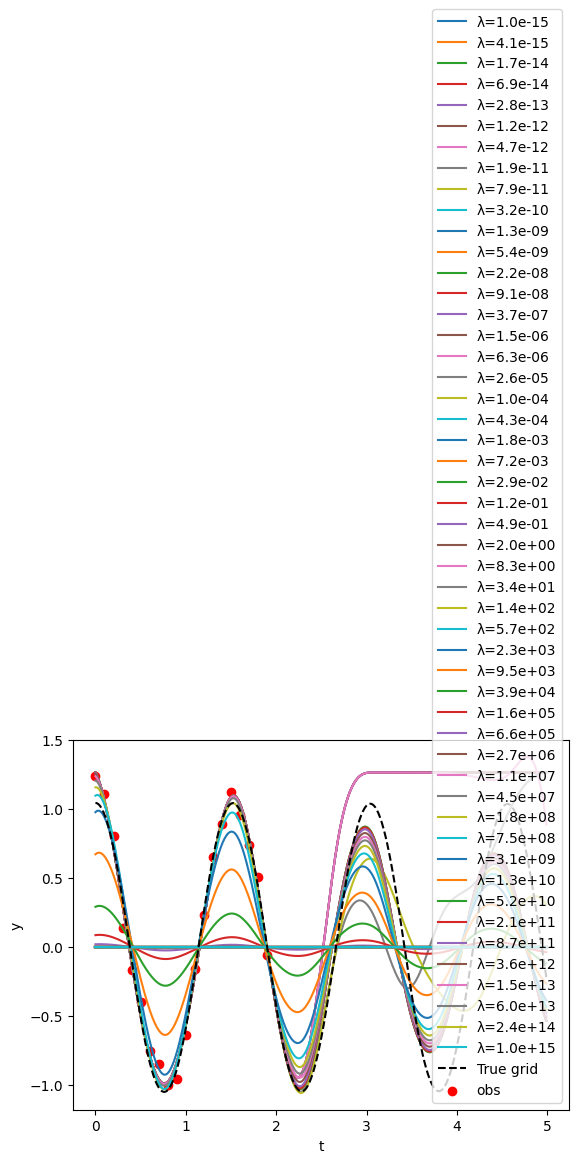

In [262]:
# Plotting
plt.figure()
lambda_log_reg = torch.logspace(-15, 15, 50)
# Initialise solutions vector
solutions = torch.zeros(50, len(t_grid))

for i in range(len(lambda_log_reg)):
  # Augment the design matrix and observation vector
  X_aug = torch.cat([A_obs@B_mat, torch.sqrt(lambda_log_reg[i]) * L], dim=0)
  y_aug = torch.cat([y_obs.type(torch.float32), torch.zeros(D2.shape[0])])

  # Solution using least squares with regularisation
  lstsq_result_reg = torch.linalg.lstsq(X_aug, y_aug)
  w_reg = lstsq_result_reg.solution

  solutions[i] = B_mat@w_reg
  plt.plot(t_grid, solutions[i], label=f'λ={lambda_log_reg[i]:.1e}')

plt.plot(t_grid, y_true, label = 'True grid', color = 'k', linestyle='--')
plt.scatter(t_fit_trajectory[::10], y_obs, label='obs', color='red')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc = 'lower right')
plt.show()

## 8. Using the hold-out set
**Your tasks**:

- Choose the best lambda from the above by computing the error on the hold-out set.

- Compare this to the pure data fit.  

- Discuss the performance of each.



In [263]:
from sklearn.metrics import mean_squared_error

errors = torch.zeros(50)
lambda_log_reg = torch.logspace(-15, 15, 50)

# Convert theta_pred to tensor
theta_pred_tensor = torch.tensor(theta_pred)
theta_fit_tensor = torch.tensor(theta_fit)

# Calculate the errors for each lambda value
for i in range(len(lambda_log_reg)):
    holdout_error = solutions[i][split[0][0]:]
    errors[i] = mean_squared_error(theta_pred_tensor, holdout_error)

best_lambda_index = torch.argmin(errors)
best_linear_ode = solutions[best_lambda_index]

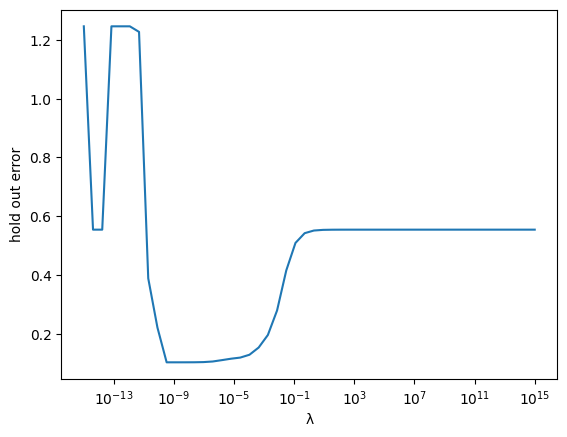

In [264]:
plt.figure()
plt.plot(lambda_log_reg, errors)
plt.xscale('log')
plt.xlabel('λ')
plt.ylabel('hold out error')
plt.show()

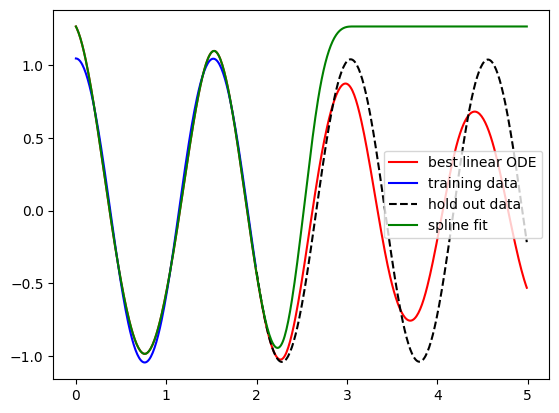

In [265]:
plt.figure()

plt.plot(t_grid, best_linear_ode, label='best linear ODE', color='red')
plt.plot(t_fit_trajectory, theta_fit, label='training data', color='blue')
plt.plot(t_pred_trajectory, theta_pred, label='hold out data', color = 'k', linestyle = '--')
plt.plot(t_grid, y_fitted, label='spline fit', color='green')

plt.legend()
plt.show()